In [1]:
import tensorflow as tf
import numpy as np
from livelossplot import PlotLossesKeras

In [2]:
mnist = tf.keras.datasets.mnist
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()
x_train_full, x_test = x_train_full / 255.0, x_test / 255.0

вычесть среднее разделить на std

In [3]:
x_train_full.shape, y_train_full.shape

((60000, 28, 28), (60000,))

In [4]:
n_values = 10

y_train_full_one_hot = np.eye(n_values)[y_train_full]
y_test_one_hot = np.eye(n_values)[y_test]

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_validation, y_train_one_hot, y_validation_one_hot = train_test_split(
    x_train_full, y_train_full_one_hot, stratify=y_train_full, test_size=0.1)

In [6]:
x_train.shape, x_validation.shape, y_train_one_hot.shape, y_validation_one_hot.shape

((54000, 28, 28), (6000, 28, 28), (54000, 10), (6000, 10))

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((x_validation, y_validation_one_hot))

In [8]:
train_dataset = train_dataset.shuffle(
    buffer_size = 1024, reshuffle_each_iteration=True
)

In [9]:
batch_size = 32

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation = 'softmax'),
])

In [11]:
optim = 'adam'
loss = tf.keras.losses.CategoricalCrossentropy()
epochs = 40
metrics = ['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()] 

In [12]:
model.compile(
    loss=loss,
    optimizer= optim,
    metrics = metrics,
)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-trai

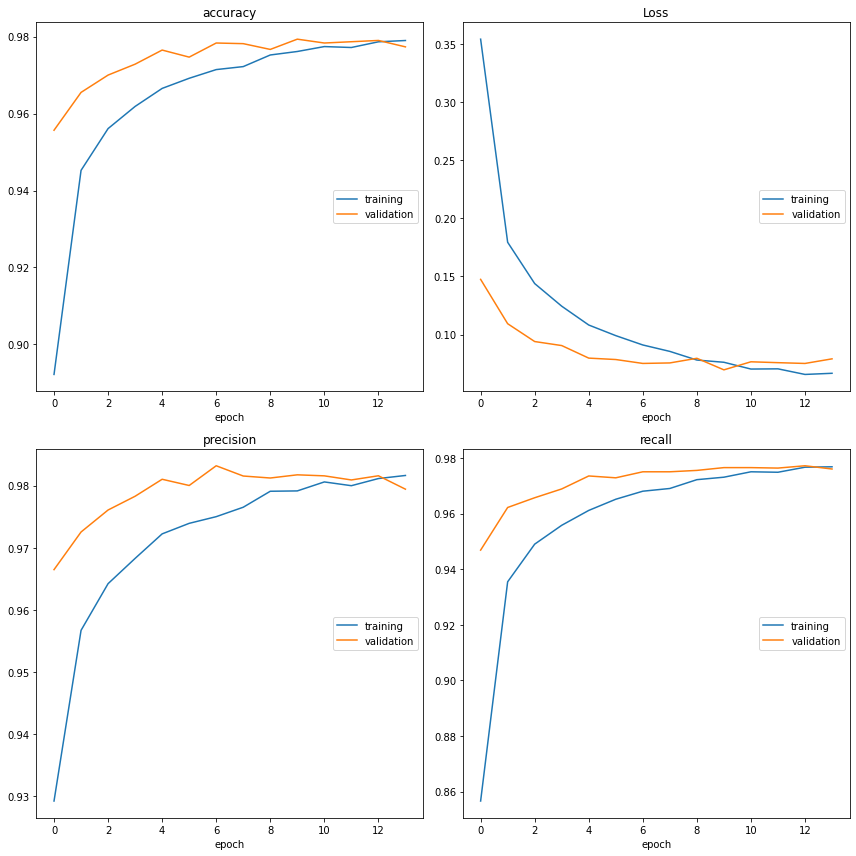

accuracy
	training         	 (min:    0.892, max:    0.979, cur:    0.979)
	validation       	 (min:    0.956, max:    0.979, cur:    0.977)
Loss
	training         	 (min:    0.066, max:    0.354, cur:    0.067)
	validation       	 (min:    0.070, max:    0.148, cur:    0.079)
precision
	training         	 (min:    0.929, max:    0.982, cur:    0.982)
	validation       	 (min:    0.966, max:    0.983, cur:    0.979)
recall
	training         	 (min:    0.857, max:    0.977, cur:    0.977)
	validation       	 (min:    0.947, max:    0.977, cur:    0.976)
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0666 - accuracy: 0.9790 - recall: 0.9768 - precision: 0.9816 - val_loss: 0.0791 - val_accuracy: 0.9773 - val_recall: 0.9760 - val_precision: 0.9794


In [14]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, min_delta=0.001)

model.fit(train_dataset, validation_data=val_dataset,
          epochs=epochs, 
          callbacks=[PlotLossesKeras(), early_stopping_callback],
          verbose=True,
          shuffle=True
         )

In [16]:
model.evaluate(x_test, y_test_one_hot)

313/313 [==============================] - 0s 1ms/step - loss: 0.0755 - accuracy: 0.9795 - recall: 0.9783 - precision: 0.9816


[0.07545608282089233,
 0.9794999957084656,
 0.9782999753952026,
 0.9816375970840454]

## description
№ эксперемента | layers | overfitting | comment 
---|---|---|---
1 |Flatten, Dense(128, 'relu'), Dense(10, 'softmax')| yes | val loss перестал падать на 6 эпохе, модель запомнила train и метрики на нем были близки к 100% 
2 |тоже самое + Dense(128, 'relu')|yes|показатели на валидации были хуже чем на train
3 |Flatten, Dense(128, 'relu'), Dropout(0.3), Dense(10, 'softmax')|no| до 10 эпохи показатели на валидации были лучше чем на train 
4 |Flatten, BatchNorm, Dense(128, 'relu'), Dense(10, 'softmax')|yes| худший результат на валидации (почти тоже самое если Batchnorm после Dense)
5 |Flatten, Dense(128, 'relu'), Dropout(0.3),Dense(128, 'relu'), Dropout(0.2), Dense(10, 'softmax')|no|показатели на валидации были близки к train



## result
№ эксперемента | max validation accuracy | min validation loss | test accuracy | test precision | test recall | test loss
---|---|---|---|---|---|---
1 |0.975|0.088|0.9758 |0.9774|0.9752|0.0879
2 |0.978|0.103|0.9752 |0.9757|0.9746|0.1389
3 |**0.980**|**0.072**|0.9802 |0.9810|**0.9790**|0.0765
4 |0.969|0.124|0.9745 |0.9761|0.9733|0.1243
5 |0.977|0.083|**0.9800** |**0.9815**|0.9783|**0.0755**


## выводы

1. больше слоев, не значил лучше результат
2. нормализация нужнa, но не всегда BatchNorm
3. Dropout лучше BatchNorm (в этой задаче)
4. способы оптимизации на этой задачи ничего не изменили (использовал "Adam", "SGD", "Optimizer")
